<a href="https://colab.research.google.com/github/arkeodev/demistify_deep_learning_applications/blob/main/Simple_Diffusion_Models/diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Diffusion Models in Deep Learning

## Introduction

Diffusion Models are a relatively recent addition to the family of generative models, gaining prominence for their impressive ability to generate high-quality, high-resolution images. These models work by gradually transforming a distribution of pure noise into a distribution resembling the training data through a series of learned reverse diffusion steps.

Diffusion Models have quickly risen to prominence for several reasons, particularly in their application to generating high-resolution images:

1. **Quality and Detail:** They have been shown to produce images of exceptional quality and detail, surpassing the capabilities of previous state-of-the-art models in many cases. This quality is attributed to the model's ability to learn intricate data distributions through the reverse diffusion process.

2. **Flexibility and Control:** By conditioning the generation process on various factors, such as text descriptions or class labels, they can produce images that not only look realistic but also match specific criteria or artistic styles.

3. **Stability in Training:** Unlike Generative Adversarial Networks (GANs), which can be challenging to train due to issues like mode collapse and instability, Diffusion Models exhibit more stable training dynamics.

4. **Robustness and Diversity:** These models can generate a diverse set of outputs, capturing the variability present in the training data.

![Diffusion Models](https://raw.githubusercontents.com/arkeodev/demistify_deep_learning_applications/main/Simple_Diffusion_Models/images/Diffusion%20Models.png#:~:text=Copy-,permalink,-%E2%8C%98)

## Theoretical Background


Diffusion Models are a class of generative models that simulate a process known as diffusion to transform data from a complex distribution into a simpler one, typically Gaussian noise, and vice versa. This transformation happens over a series of steps, making the model capable of generating new data samples that resemble the original distribution.

As outlined in the definitions within my GitHub repository, this blog item is also a learning journey for me. Given the complexity and depth of the subject, I acknowledge that now I cannot provide a complete mathematical proof of the forward and backward processes as comprehensively as it is presented in the video available at: [Diffusion Models | Paper Explanation | Math Explained](https://www.youtube.com/watch?v=HoKDTa5jHvg).

Therefore, for those seeking a thorough understanding of the mathematical foundations of diffusion models, I strongly recommend watching this video. It offers detailed insights into the mechanisms driving these powerful generative models, complementing the foundational knowledge shared in this blog.

Here I'll just try to put some important aspects to keep the completeness of the outline.

The process can be broken down into two main phases:

- Forward Process (Diffusion): This process gradually adds noise to the data over a predefined number of steps until the data is completely converted into random noise. The noise addition at each step is typically Gaussian, and the amount of noise added is controlled to ensure the process can be reversed.

- Reverse Process (Denoising): In this phase, the model learns to reverse the forward diffusion process. Starting from noise, it iteratively removes the added noise, step by step, reconstructing the data back to its original form. This process is learned during training by optimizing the model to predict the noise that was added at each step in the forward process, effectively learning the data distribution.



### Forward Diffusion Process


The forward diffusion process systematically transitions data from its original state into a state of pure noise through a sequence of steps. Mathematically, it can be modeled as a Markov chain where each step adds Gaussian noise to the data, incrementally moving it towards a predetermined noise distribution, typically Gaussian.

This process is modeled incrementally, but to avoid computational intensity, a reparameterization technique is utilized. Here's how the process works, mathematically:

- **$(\alpha)$ Calculation:**

  Each $(\alpha_t)$ value is calculated from the corresponding $(\beta_t)$ value using the formula:
$$
\alpha_t = 1 - \beta_t
$$

  This represents the proportion of the original image that remains after noise is added at step `t`.

- **$(\alpha_{bar})$ (Cumulative Alpha) Calculation**:

  The cumulative product of alphas, $(\alpha_t)$, up to step $(t)$ is computed as:

  $$
  \alpha_{\text{bar}_t} = \prod_{s=0}^{t} \alpha_s
  $$

  This cumulative product represents the total proportion of the original image that remains after noise has been added up to timestep $(t)$.
  
  &nbsp;

- **Direct Noise Sampling**:

  Instead of adding noise step by step, the noisy image at timestep `t` can be directly sampled using:

  $$
  x_t = \sqrt{\alpha_{\text{bar}_t}} \cdot x_0 + \sqrt{1 - \alpha_{\text{bar}_t}} \cdot \epsilon
  $$

  where $(x_0)$ is the original image and $(epsilon)$ is a noise vector sampled from a standard Gaussian distribution, $( \epsilon \sim \mathcal{N}(0, I) )$.

  This method allows the model to efficiently simulate the noisy image at any timestep without the need to sequentially add noise, which would otherwise be computationally expensive.

Files already downloaded and verified


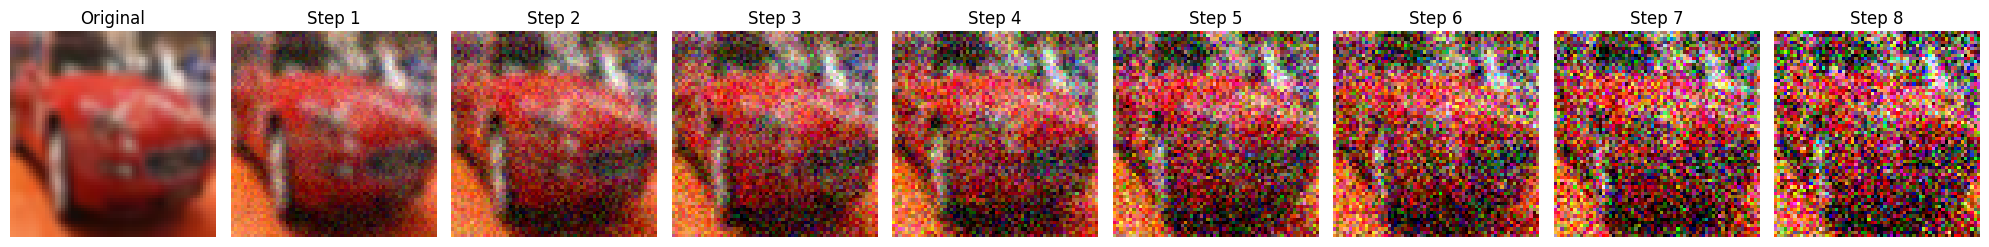

In [10]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Define the variance schedule beta_t for a particular time step t
def get_beta_t(t, T=1000, beta_start=0.0001, beta_end=0.02):
    return beta_start + (beta_end - beta_start) * (t / T)

# Compute alpha_t and its cumulative product from beta_t
def get_alpha_t(t, T=1000, beta_start=0.0001, beta_end=0.02):
    beta_t = get_beta_t(t, T, beta_start, beta_end)
    alpha_t = 1 - beta_t
    alpha_t_cum = torch.prod(torch.tensor([1 - get_beta_t(s, T, beta_start, beta_end) for s in range(1, t+1)]))
    return alpha_t, alpha_t_cum

# Simulate the forward diffusion process for an image at time step t
def forward_diffusion_step(image, t, T=1000, beta_start=0.0001, beta_end=0.02):
    alpha_t, alpha_t_cum = get_alpha_t(t, T, beta_start, beta_end)
    noise = torch.randn_like(image)
    return torch.sqrt(alpha_t_cum) * image + torch.sqrt(1 - alpha_t_cum) * noise

# Load a sample image from a dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor()
])

# Using CIFAR10 as an example dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
image, _ = dataset[5]  # Get the fifth image and its label
image = image[:3, :, :]  # Use only the first three channels if it's not already in RGB


# Display the original image
plt.figure(figsize=(20, 4))  # Adjusted figure size for better display
plt.subplot(1, 9, 1)  # Adjusted for a total of 9 images (1 original + 8 steps)
plt.imshow(image.permute(1, 2, 0))
plt.title('Original')
plt.axis('off')

# Apply forward diffusion steps and display images
T = 8  # Let's show 8 steps for simplicity
for t in range(1, T + 1):
    noisy_image = forward_diffusion_step(image, t, T)
    plt.subplot(1, 9, t+1)  # Corrected to match the total number of images
    plt.imshow(noisy_image.permute(1, 2, 0).clamp(0, 1))
    plt.title(f'Step {t}')
    plt.axis('off')

plt.tight_layout()
plt.show()

![Forward Diffusion Process](https://raw.githubusercontents.com/arkeodev/demistify_deep_learning_applications/main/Simple_Diffusion_Models/images/Forward_Process_2.png#:~:text=Copy-,permalink,-%E2%8C%98)

### Reverse Diffusion Process

The reverse process aims to learn the reverse of the forward process, effectively denoising or reconstructing the original data from noise. It involves learning a sequence of conditional distributions that gradually transform the noise back into the data distribution. This reverse process is parameterized by a neural network that predicts the noise added at each step of the forward process, thereby allowing the model to iteratively denoise the data.

The reverse process can be mathematically modeled as:
$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{\sqrt{1-\alpha_t}} \epsilon_\theta(x_t, t))
$$
where $(\epsilon_\theta(x_t, t))$ is the noise predicted by the neural network for the noisy data $(x_t)$ at step $(t)$.



![Reversal Diffusion Process](https://raw.githubusercontents.com/arkeodev/demistify_deep_learning_applications/main/Simple_Diffusion_Models/images/Reversal_Process.png#:~:text=Copy-,permalink,-%E2%8C%98)

### Importance of Variance, Noise, and Mean

Variance: in the diffusion model is used to control the rate at which noise is added to the data in the forward process. By managing the variance through the $( \beta_t )$ schedule, we ensure a smooth transition from data to noise, which is essential for the model to learn the reverse process effectively. A carefully chosen $( \beta_t )$ schedule leads to stable training and better quality reconstructions.

Predicted Noise: During the reverse diffusion process, the model predicts the noise that was added to the image at each timestep of the forward diffusion process. This prediction is effectively an estimation of the mean of the noise distribution that was added to the original image to get to the noisy image at the current timestep.

The interplay between variance and noise defines the diffusion process's efficiency and effectiveness. Learning to accurately predict the noise added during the forward process allows the model to effectively reverse this process, generating new samples that faithfully resemble the original data distribution.

![Noise Scheduler](https://raw.githubusercontents.com/arkeodev/demistify_deep_learning_applications/main/Simple_Diffusion_Models/images/Importance_of_Noise_Scheduler.png#:~:text=Copy-,permalink,-%E2%8C%98)

### Noise Scheduling Methods

Regarding the best way to use $(\beta_t)$, different scheduling strategies are employed, each with its benefits:

- **Linear Schedule**: Initially, the default implementation in the foundational DDPM paper used a linear schedule for $(\beta_t)$, which increases the noise level in a uniform manner from the start to the end of the diffusion process. While this approach is simple and intuitive, it may not always be the most effective for preserving the structure of the data in the initial timesteps.

- **Cosine Schedule**: As detailed in the improved DDPM paper, a cosine schedule can offer advantages over a linear schedule. It modulates $(\beta_t)$ such that it retains more structure of the original data in the early diffusion steps, gradually introducing larger noise levels only in the later steps. This approach can lead to improved stability during the reverse diffusion process.

- **Learned Schedule**: Some recent models propose learning the noise schedule directly from the data, incorporating it into the training process. The model thus optimizes both the reverse diffusion process and the optimal schedule for $(\beta_t)$.

- **Hybrid Approaches**: Combining predefined schedules with learnable parameters, hybrid approaches seek to leverage the stability of known schedules with the adaptability of learned parameters to tailor the noise schedule to specific datasets or generative tasks.

- In the latest advancements, such as Denoising Diffusion Implicit Models (DDIMs) and models using classifier-free guidance, the treatment of $(\beta_t)$ has become increasingly sophisticated. These methods facilitate the rapid and diverse generation of high-quality images, highlighting $(\beta_t)$'s critical role in shaping the capabilities and performance of diffusion models.

![Cosine Scheduling vs. Linear Scheduling](https://raw.githubusercontents.com/arkeodev/demistify_deep_learning_applications/main/Simple_Diffusion_Models/images/Linear_vs_Cosine_Scheduler.png#:~:text=Copy-,permalink,-%E2%8C%98)

### Positional Encoding in Diffusion Models

Positional encoding plays a crucial role in diffusion models, especially since these models process data across a sequence of timesteps in both the forward and reverse diffusion processes. The key importance of positional encoding in diffusion models can be summarized as follows:

1. **Time Step Awareness**:
   - Diffusion models operate over a sequence of timesteps, gradually adding noise to the data in the forward process and removing it in the reverse process. Positional encoding injects information about the specific timestep into the model, enabling it to be aware of the current stage in the diffusion process. This awareness is crucial for the model to apply the correct level of noise or denoising at each step.

2. **Alignment of Forward and Reverse Processes**:
   - For the reverse process to effectively undo the noise added during the forward process, it must closely align with the corresponding timestep. Positional encoding ensures that for any given timestep during the reverse process, the model can accurately predict the noise that was added at that exact step in the forward process, allowing for precise and effective denoising.

3. **Improved Temporal Resolution**:
   - By incorporating positional encoding, diffusion models gain a finer temporal resolution, meaning they can distinguish between the subtle differences in noise characteristics across timesteps. This improved resolution enhances the model's ability to generate high-quality outputs by accurately modeling the noise distribution at each step.

4. **Enhanced Model Performance**:
   - Positional encoding enables the model to leverage the temporal structure of the diffusion process, which can significantly improve the overall performance of the model. It allows the model to make informed predictions based on not just the current data but also its position in the sequence of diffusion steps, leading to more accurate noise prediction and image generation.

5. **Enables Flexible and Dynamic Processing**:
   - With positional encoding, diffusion models can dynamically adjust to different lengths of the diffusion process. For example, models can be trained or fine-tuned to operate with fewer or more steps than they were originally designed for, providing flexibility in how the model is deployed.

### A Sample Implementation of Forward and Reverse Processes

The Python code snippet provided below simulates both the forward and reverse diffusion processes for a simplified example with 5 pixels, across 5 timesteps.

In [6]:
import numpy as np

# Assume we have a pre-determined schedule of beta values and corresponding alpha values for the diffusion process.
num_steps = 5
beta_values = np.linspace(0.0001, 0.02, num_steps)  # Linear beta schedule
alpha_values = 1 - beta_values  # Alpha values computed from beta values
alpha_bar_values = np.cumprod(alpha_values)  # Cumulative product of alpha values for the forward diffusion process.

# Initialize an original image (data) for simplicity.
original_data = np.array([0.8, 0.2, -0.5, 0.3, -0.1])

# Function to perform the forward diffusion process.
def forward_diffusion(data, alpha_bar_values):
    '''
    For each timestep, it adds Gaussian noise to the original data according
    to the alpha cumulative product, resulting in increasingly noisy data.
    '''
    noisy_data = data.copy()
    for t in range(1, num_steps):
        beta_t = beta_values[t]
        alpha_t = alpha_values[t]
        alpha_bar_t = alpha_bar_values[t]
        noise = np.random.normal(0, np.sqrt(1 - alpha_bar_t), data.shape)
        noisy_data = np.sqrt(alpha_bar_t) * noisy_data + noise
    return noisy_data

# Function to predict noise (for illustration purposes, we use a simple model).
def predict_noise(noisy_data, alpha_bar_values, t):
    '''
    A placeholder function that simulates the noise prediction of the trained
    model. In an actual model, this would be the output based on the model's
    weights and the input noisy data.
    Here, we simply approximate it with some noise scaling based on alpha values.
    '''
    return (noisy_data - np.sqrt(alpha_bar_values[t]) * original_data) / np.sqrt(1 - alpha_bar_values[t])

# Function to perform the reverse diffusion process.
def reverse_diffusion(noisy_data, alpha_values, alpha_bar_values):
    '''
    Performs the reverse diffusion process to reconstruct the original data
    from the noisy data produced in the last step of the forward process.

    Applies the reverse diffusion formula at each timestep to progressively
    denoise the data, using the predicted noise from the mock function and
    the alpha cumulative product values.
    '''
    x_reconstructed = noisy_data.copy()
    for t in reversed(range(1, num_steps)):
        alpha_t = alpha_values[t]
        alpha_bar_t = alpha_bar_values[t]
        noise_prediction = predict_noise(x_reconstructed, alpha_bar_values, t)
        x_reconstructed = (x_reconstructed - np.sqrt(1 - alpha_t) * noise_prediction) / np.sqrt(alpha_t)
    return x_reconstructed

# Perform forward diffusion to simulate the noisy data.
noisy_data_at_last_step = forward_diffusion(original_data, alpha_bar_values)

# Perform reverse diffusion to reconstruct the original data from the noisy data.
reconstructed_data = reverse_diffusion(noisy_data_at_last_step, alpha_values, alpha_bar_values)

# Output the results.
print("Original Data:      ", original_data)
print(f"Noisy Data (Last Step): {noisy_data_at_last_step}")
print("Reconstructed Data: ", reconstructed_data)

Original Data:       [ 0.8  0.2 -0.5  0.3 -0.1]
Noisy Data (Last Step): [ 0.6506     -0.10661233 -0.76823526  0.51923162  0.30489381]
Reconstructed Data:  [ 0.79993467  0.19993097 -0.50002994  0.30002937 -0.09991625]


## The Steps of Training a Diffusion Model

1. **Preprocessing Images**:
    - Begin by normalizing a batch of images so that each has a mean of zero and a variance of one.
      $$
      x_{\text{norm}} = \frac{x - \mu}{\sigma}
      $$
      where $(x)$ is the original pixel value, $(\mu)$ is the mean, and $(\sigma)$ is the standard deviation of the image pixel values.

2. **Sampling Noise**:
   - Draw noise samples that correspond in shape to the input images.
      $$
      \epsilon \sim \mathcal{N}(0, I)
      $$
     where $(\epsilon)$ is the noise vector, and $(\mathcal{N}(0, I))$ denotes a multivariate normal distribution with mean 0 and identity covariance matrix.

3. **Sampling Diffusion Steps**:
   - Random selection of diffusion steps introduces stochasticity into the process.

4. **Calculating Noise and Signal Levels**:
  - Based on the chosen diffusion times, calculate the respective noise and signal levels according to a predefined cosine diffusion schedule.

    $(\beta_t)$ is the noise level schedule,

    $(\alpha_t = 1 - \beta_t)$ for signal retention level,

  $$
  (\bar{\alpha}_t = \prod_{i=0}^{t} \alpha_i)
  $$
    is the cumulative signal retention.

5. **Mixing Noise and Signal**:
   - Apply the computed noise and signal levels to the input images, thereby synthesizing noisy versions of the images.
   - At timestep $(t)$:
$$
  x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon
$$

6. **Performing the Denoising Task**:
   - With the noisy images prepared, the network is tasked with predicting the applied noise. This prediction is then used to reverse the noise addition process, effectively denoising the images.

   - The task involves predicting $(\epsilon)$ from $(x_t)$, often without a direct formula as it depends on the model architecture.

7. **Determining Loss**:
   - The model's accuracy in predicting the noise is quantified by calculating the loss, specifically using the MSE or Log Likelihood between the predicted noise and the actual noise added to the images.
    $$
    \text{Loss} = \frac{1}{N} \sum (\epsilon - \hat{\epsilon})^2 \]
    $$
     where $(\hat{\epsilon})$ is the predicted noise by the model.

8. **Optimizing the Model**:
   - The optimization step involves applying gradient descent:
     $$
      \theta_{\text{new}} = \theta - \eta \nabla_{\theta} \text{Loss}
     $$

     where
     
     $(\theta)$ represents model parameters,

     $(\eta)$ is the learning rate,

     $(\nabla_{\theta} \text{Loss})$ is the gradient of the loss with respect to the model parameters.


## Implementing Diffusion Models with PyTorch and PyTorch Lightning

In my exploration and implementation of diffusion models, I have decided to utilize the PyTorch implementation provided by [dome272](https://github.com/dome272/Diffusion-Models-pytorch/tree/main). This decision is driven by several key factors that make this implementation particularly appealing for my project:

- Clarity of Implementation: The codebase is well-organized and clearly implements the core concepts of diffusion models, making it accessible for researchers and practitioners alike.

- Standard Unet Implementation: The use of a standard Unet architecture in this implementation ensures that the model is both robust and capable of capturing the complex patterns necessary for effective denoising.

- Comprehensive Paper Implementation: This repository implements two foundational papers in the field:
  - [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf)
  - [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2102.09672.pdf)
  
  By building upon these papers, the implementation provides a solid foundation for exploring the nuances of diffusion models.

- Simplification of Critical Concepts: Before starting the implementation here, above I have presented some critical components of diffusion models in a simplified manner. This groundwork will complement the deeper understanding of the code.

While dome272's implementation serves as an excellent starting point, I plan to introduce two significant customizations to tailor the project to my specific preferences:

1. **Dataset**: I will be utilizing a different dataset for training the model.

2. **Training Framework**: Instead of using the standard PyTorch training loops provided in the implementation, I will be leveraging [PyTorch Lightning](https://www.pytorchlightning.ai/).

### Setting up the environment

In [3]:
! pip install pytorch_lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split

from torchvision import datasets, transforms
import torchvision.utils as vutils

import pytorch_lightning as pl
from pytorch_lightning import Trainer

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage
from skimage.color import rgb2gray
from sklearn.cluster import KMeans

import os
from pathlib import Path
from typing import Tuple

from tqdm.notebook import trange, tqdm
from IPython.display import clear_output

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cpu device


### Data Preparation and Preprocessing

### Building the Model Architecture

#### Diffusion Tools

In [10]:
class Diffusion:
    """
    A class for managing the diffusion process in generating images, based on the noise scheduling strategy.
    """

    def __init__(self, noise_steps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02,
                 img_size: int = 64, device: torch.device = device) -> None:
        # Initialize parameters for the diffusion process
        self.noise_steps = noise_steps  # Total number of diffusion steps
        self.beta_start = beta_start  # Starting value of beta for the noise schedule
        self.beta_end = beta_end  # Ending value of beta for the noise schedule
        self.img_size = img_size  # Size of the images to generate
        self.device = device  # Computational device (CPU or GPU)

        # Prepare and initialize the beta, alpha, and alpha_hat schedules
        self.beta = self.prepare_noise_schedule().to(device)  # Linear schedule of beta values
        self.alpha = 1. - self.beta  # Alpha values derived from beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)  # Cumulative product of alpha for each step

    def prepare_noise_schedule(self) -> Tensor:
        """Generates a linearly spaced tensor for the noise schedule from beta_start to beta_end."""
        # Create a linear space for beta values from beta_start to beta_end
        return torch.linspace(start=self.beta_start, end=self.beta_end, steps=self.noise_steps)

    def noise_images(self, x: Tensor, t: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Adds noise to the original images based on the specified timesteps.
        """
        # Calculate the square roots of alpha_hat and (1-alpha_hat) for the given timesteps
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat[t])[:, None, None, None]

        # Generate random noise with the same shape as the input images
        e = torch.randn_like(x)

        # Apply the noise formula: noisy_image
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * e, e

    def sample_time_stamps(self, n: int) -> Tensor:
        """Randomly samples timesteps for the diffusion process."""
        # Randomly select 'n' timesteps from the noise schedule
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model: nn.Module, n: int) -> Tensor:
        """
        Generates new images by performing the reverse diffusion process.
        """
        print(f"Sampling {n} new images...")
        model.eval()
        with torch.no_grad():
            # Initialize random noise as starting point for generation
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)

            # Reverse diffusion process from the last step back to the first
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0, leave=True):

                # Prepare the timestep tensor for the current step 'i'
                t = (torch.ones(n) * i).long().to(self.device)

                # Obtain the predicted noise from the model
                predicted_noise = model(x, t)

                # Retrieve alpha, alpha_hat, and beta values for the current timestep
                # [:, None, None, None] is used to match the shape of the tensors
                # (alpha, alpha_hat, beta) with the shape of the input images x
                # for broadcasting operations.
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]

                # Generate random noise or zero noise depending on the step
                noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)

                # Apply the reverse diffusion update formula
                x = (x - ((1. - alpha) / torch.sqrt(1. - alpha_hat)) * predicted_noise) / torch.sqrt(alpha) + torch.sqrt(beta) * noise

            # Clamp, normalize, and convert the final images to uint8 format
            x = ((x.clamp(-1, 1) + 1) / 2 * 255).type(torch.uint8)
        model.train()  # Re-enable training mode for the model
        return x


#### Unconditional UNet Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

class SelfAttention(nn.Module):
    """
    Implements a self-attention mechanism over image features.

    Attributes:
        channels (int): Number of channels in the input feature map.
        size (int): Spatial size of the input feature map (height = width).
        mha (nn.MultiheadAttention): Multi-head attention module.
        ln (nn.LayerNorm): Layer normalization.
        ff_self (nn.Sequential): Feed-forward network for self-attention outputs.
    """
    def __init__(self, channels: int, size: int):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        # Multi-head attention with 'batch_first=True' to accommodate the batch size as the first dimension.
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        # Layer normalization applied to the channel dimension.
        self.ln = nn.LayerNorm([channels])
        # Feed-forward network applied after self-attention.
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Reshape and swap axes to match the input requirements of MultiheadAttention.
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        # Apply layer normalization before attention.
        x_ln = self.ln(x)
        # Compute self-attention.
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        # Add the attention output to the original input (residual connection).
        attention_value = attention_value + x
        # Apply feed-forward network to the self-attention outputs.
        attention_value = self.ff_self(attention_value) + attention_value
        # Reshape back to the original shape.
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class DoubleConv(nn.Module):
    """
    A double convolution module optionally followed by a residual connection.

    Attributes:
        residual (bool): If True, adds a residual connection around the convolutions.
        double_conv (nn.Sequential): Sequential container of two convolutional layers.
    """
    def __init__(self, in_channels: int, out_channels: int, mid_channels: int = None, residual: bool = False):
        super(DoubleConv, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        # Two convolutional layers with Group Normalization and GELU activation.
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply residual connection if enabled.
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    """
    A module to perform downsampling followed by double convolution on the input features.

    Attributes:
        maxpool_conv (nn.Sequential): A sequential container that performs max pooling followed by double convolutions.
        emb_layer (nn.Sequential): A feed-forward network to process the time embedding and integrate it into the feature map.
    """
    def __init__(self, in_channels: int, out_channels: int, emb_dim: int = 256):
        super().__init__()
        # Max pooling reduces the spatial dimensions by half, and double convolution processes the pooled features.
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        # Embedding layer to introduce time-dependent information to the features.
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the Down module.

        Parameters:
            x (torch.Tensor): The input feature map.
            t (torch.Tensor): The time embedding.

        Returns:
            torch.Tensor: The processed feature map with time information added.
        """
        x = self.maxpool_conv(x)
        # Calculate the time embedding for each feature map and add it to the processed features.
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class Up(nn.Module):
    """
    A module to perform upsampling followed by convolution on the concatenated input features.
    """
    def __init__(self, in_channels: int, out_channels: int, emb_dim: int = 256):
        super().__init__()
        # Upsample to increase the spatial dimensions, followed by convolution to process the features.
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        # A sequential container that processes the concatenated features.
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        # Embedding layer to introduce time-dependent information to the features.
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x: torch.Tensor, skip_x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the Up module.

        Parameters:
            x (torch.Tensor): The input feature map from the previous layer.
            skip_x (torch.Tensor): The feature map from the corresponding downsampling layer for concatenation.
            t (torch.Tensor): The time embedding.
        Returns:
            torch.Tensor: The upsampled and processed feature map with time information added.
        """
        x = self.up(x)
        # Concatenate the upsampled features with the skip features from the corresponding downsampling layer.
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        # Calculate the time embedding for each feature map and add it to the processed features.
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [5]:
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

### Training the Model

In [7]:
### Training the Model

### Generating New Images

## Exploring Different Architectures Based on Diffusion Models
    - Overview of architectures like GLIDE, DALLE-2, Imagen, and Stable Diffusion
    - Their impact on the generative models landscape

## Challenges and Limitations
    - Computational requirements
    - Comparison with GANs in terms of speed and quality
    - Future directions and potential improvements

## Conclusion
    - Summary of key takeaways
    - The future of Diffusion Models in generative deep learning

## References

  - Denoising Diffusion Probabilistic Models: (https://arxiv.org/pdf/2006.11239.pdf)
  - Improved Denoising Diffusion Probabilistic Models: (https://arxiv.org/pdf/2102.09672.pdf)
  - Diffusion Model Implementation by [dome272](https://github.com/dome272) : (https://github.com/dome272/Diffusion-Models-pytorch/tree/main)
  - Paper explanation of Diffusion Models by Outlier: (https://www.youtube.com/watch?v=HoKDTa5jHvg)